In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import re
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epochs=10
batch_size=64

# 1. Load Data

In [3]:
# path='IMDB Dataset.csv'
path='/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

In [4]:
df=pd.read_csv(path)

In [5]:
# df=df.head(100)

In [6]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [7]:
max_review_length=df['review'].apply(lambda x: len(x.split())).max()
max_review_length

2470

# 2. Preprocess Data

In [8]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [9]:
remove_tag_df=df.copy()
remove_tag_df['review']=remove_tag_df['review'].apply(remove_html_tags)
remove_tag_df

<ipython-input-8-6d6e64af61d2>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
remove_tag_df['sentiment']=remove_tag_df['sentiment'].map({'positive':1, 'negative':0})
remove_tag_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [11]:
# remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

remove_url_df=remove_tag_df.copy()
remove_url_df['review']=remove_url_df['review'].apply(remove_urls)
remove_url_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [12]:
train_df, remaining = train_test_split(remove_tag_df, random_state = 42, train_size = 0.8)
valid_df, test_df = train_test_split(remaining, random_state = 42, train_size = 0.8)


# 3. Tokenize Data

In [13]:
max_length=512

In [14]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
train_encoding=tokenizer(train_df['review'].tolist(), max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
valid_encoding=tokenizer(valid_df['review'].tolist(), max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
test_encoding=tokenizer(test_df['review'].tolist(), max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')

In [16]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Đối tượng BatchEncoding
        self.labels = labels  # Danh sách các nhãn

    def __getitem__(self, idx):
        # Lấy các trường từ encodings
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }
        
        # Nếu có token_type_ids
        if 'token_type_ids' in self.encodings:
            item['token_type_ids'] = self.encodings['token_type_ids'][idx]
        
        # Thêm nhãn
        item['labels'] = torch.tensor(self.labels[idx])
        
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
print(train_encoding.keys())  # Kiểm tra các key trong encodings

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [18]:
train_dataset = CustomDataset(train_encoding, train_df['sentiment'].tolist())
valid_dataset = CustomDataset(valid_encoding, valid_df['sentiment'].tolist())
test_dataset = CustomDataset(test_encoding, test_df['sentiment'].tolist())

In [19]:
# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
for batch in train_loader:
    print(batch['input_ids'].shape)  # Kiểm tra kích thước của input_ids
    print(batch['token_type_ids'].shape)  # Kiểm tra kích thước của token_type_ids
    print(batch['attention_mask'].shape)  # Kiểm tra kích thước của attention_mask
    print(batch['labels'].shape)  # Kiểm tra kích thước của labels
    break

torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64])


# 4. Model

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Sử dụng GPU
    print("GPU is available!")
else:
    device = torch.device("cpu")   # Sử dụng CPU
    print("GPU is not available, using CPU.")

GPU is available!


In [22]:
# Khởi tạo mô hình
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device) 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [24]:
optimizer=torch.optim.Adam(model.parameters(), lr=5e-6)

In [25]:
best_val_loss = np.inf  # Giá trị validation loss tốt nhất
patience = 3  # Số epoch chờ đợi nếu validation loss không cải thiện
patience_counter = 0  # Đếm số epoch không cải thiện
best_model_weights = None  # Lưu trọng số của mô hình tốt nhất

# Tạo DataFrame để lưu loss và accuracy của từng epoch
history = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Validation Accuracy'])

model.train()
for epoch in range(epochs):  # Số epoch
    # Huấn luyện trên tập train
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        optimizer.zero_grad()
        
        # Chuyển dữ liệu sang GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Đưa dữ liệu vào mô hình
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Tính loss và cập nhật tham số
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Tính loss trung bình trên tập train
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Đánh giá trên tập validation
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Epoch {epoch + 1} - Validation"):
            # Chuyển dữ liệu sang GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Đưa dữ liệu vào mô hình
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            # Lấy logits và nhãn dự đoán
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            # Lưu kết quả (chuyển về CPU để tính toán metric)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            # Tính loss
            val_loss += outputs.loss.item()
    
    # Tính loss và độ chính xác trên tập validation
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Lưu thông tin vào DataFrame
    history.loc[epoch] = [epoch + 1, avg_train_loss, avg_val_loss, val_accuracy]

    # Kiểm tra Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter vì validation loss đã cải thiện
        best_model_weights = model.state_dict()  # Lưu trọng số tốt nhất
    else:
        patience_counter += 1  # Tăng counter nếu validation loss không cải thiện
    
    # Kiểm tra điều kiện dừng
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}!")
        break

# Load lại trọng số tốt nhất của mô hình
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Loaded the best model weights based on validation loss.")

Epoch 1 - Training: 100%|██████████| 625/625 [10:39<00:00,  1.02s/it]


Epoch 1 - Training Loss: 0.7173


Epoch 1 - Validation: 100%|██████████| 125/125 [02:01<00:00,  1.02it/s]


Epoch 1 - Validation Loss: 0.7014, Validation Accuracy: 0.4680


Epoch 2 - Training: 100%|██████████| 625/625 [10:40<00:00,  1.02s/it]


Epoch 2 - Training Loss: 0.7007


Epoch 2 - Validation: 100%|██████████| 125/125 [02:01<00:00,  1.02it/s]


Epoch 2 - Validation Loss: 0.6944, Validation Accuracy: 0.5054


Epoch 3 - Training: 100%|██████████| 625/625 [10:40<00:00,  1.03s/it]


Epoch 3 - Training Loss: 0.6938


Epoch 3 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 3 - Validation Loss: 0.6879, Validation Accuracy: 0.5406


Epoch 4 - Training: 100%|██████████| 625/625 [10:41<00:00,  1.03s/it]


Epoch 4 - Training Loss: 0.6887


Epoch 4 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 4 - Validation Loss: 0.6819, Validation Accuracy: 0.5751


Epoch 5 - Training: 100%|██████████| 625/625 [10:41<00:00,  1.03s/it]


Epoch 5 - Training Loss: 0.6834


Epoch 5 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 5 - Validation Loss: 0.6759, Validation Accuracy: 0.6126


Epoch 6 - Training: 100%|██████████| 625/625 [10:42<00:00,  1.03s/it]


Epoch 6 - Training Loss: 0.6777


Epoch 6 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 6 - Validation Loss: 0.6710, Validation Accuracy: 0.6135


Epoch 7 - Training: 100%|██████████| 625/625 [10:42<00:00,  1.03s/it]


Epoch 7 - Training Loss: 0.6739


Epoch 7 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 7 - Validation Loss: 0.6659, Validation Accuracy: 0.6275


Epoch 8 - Training: 100%|██████████| 625/625 [10:43<00:00,  1.03s/it]


Epoch 8 - Training Loss: 0.6688


Epoch 8 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 8 - Validation Loss: 0.6604, Validation Accuracy: 0.6492


Epoch 9 - Training: 100%|██████████| 625/625 [10:43<00:00,  1.03s/it]


Epoch 9 - Training Loss: 0.6645


Epoch 9 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch 9 - Validation Loss: 0.6569, Validation Accuracy: 0.6382


Epoch 10 - Training: 100%|██████████| 625/625 [10:43<00:00,  1.03s/it]


Epoch 10 - Training Loss: 0.6598


Epoch 10 - Validation: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]

Epoch 10 - Validation Loss: 0.6519, Validation Accuracy: 0.6569
Loaded the best model weights based on validation loss.


In [26]:
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        # Chuyển dữ liệu sang GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Đưa dữ liệu vào mô hình
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Lấy logits và nhãn dự đoán
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        # Lưu kết quả (chuyển về CPU để tính toán metric)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Tính độ chính xác
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s]

Test Accuracy: 0.6535


# 5. Evaluate

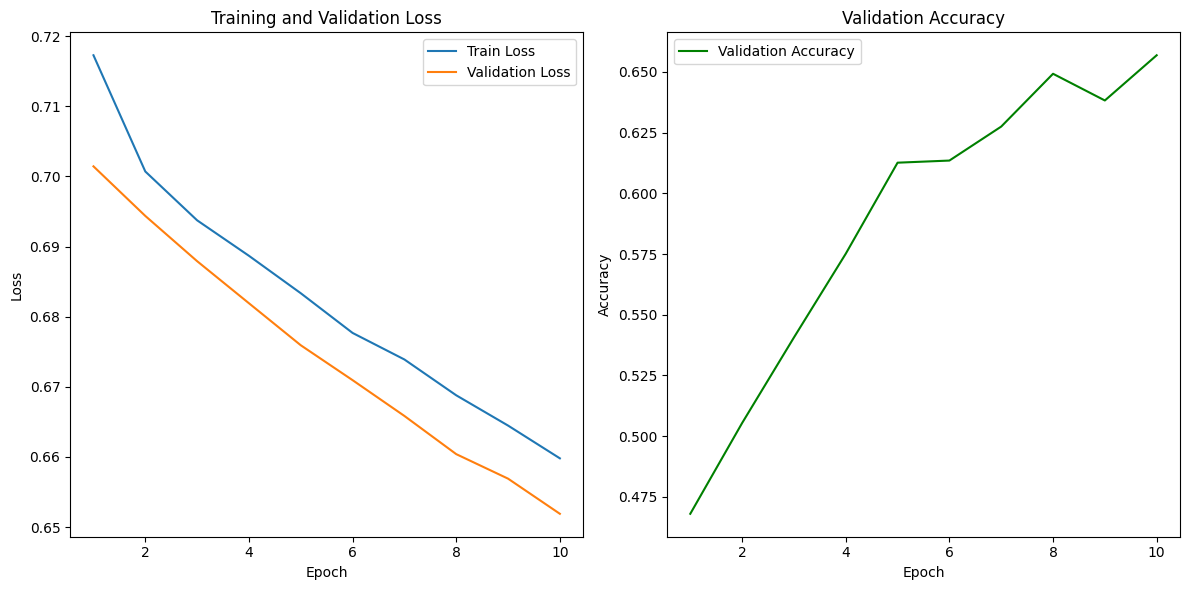

In [27]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Validation Accuracy'], label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# Giả sử bạn có các nhãn thực tế và nhãn dự đoán
true_labels = test_labels # Nhãn thực tế
pred_labels = test_preds  # Nhãn dự đoán

# Tính confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Tính Recall, Precision, F1-score
recall = recall_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")


Recall: 0.8432
Precision: 0.6116
F1-score: 0.7089


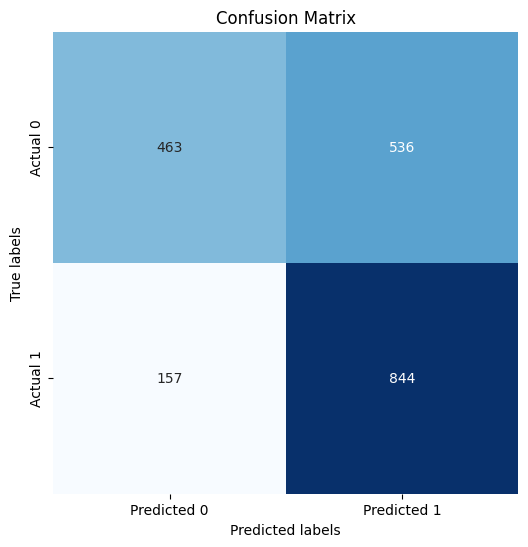

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()